In [1]:
!pip install gtfs-realtime-bindings geopandas contextily --quiet

In [22]:
from google.transit import gtfs_realtime_pb2
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import py7zr
import re

In [6]:
tvarb_tid = pd.read_csv('./data/2-working-data/tvarbanan-trips.csv', index_col=0)
tvarb_tid.trip_id = tvarb_tid.trip_id.astype(str)
tvarb_tid.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id,agency_id,route_short_name,route_long_name,route_type,route_desc
26016,9011001003000000,415,14010000580359261,NaN,1,454,14010000000001001,30,Tvärbanan,900,Tvärbanan
26017,9011001003000000,415,14010000580359570,NaN,1,454,14010000000001001,30,Tvärbanan,900,Tvärbanan
26018,9011001003000000,416,14010000580360974,NaN,1,454,14010000000001001,30,Tvärbanan,900,Tvärbanan
26019,9011001003000000,416,14010000580361045,NaN,1,454,14010000000001001,30,Tvärbanan,900,Tvärbanan
26020,9011001003000000,147,14010000580364294,NaN,1,454,14010000000001001,30,Tvärbanan,900,Tvärbanan


In [36]:
# Select files from the archive
with py7zr.SevenZipFile('./data/0-koda-gtfs-rt/vp/2021-12-01.7z', 'r') as archive:
    allfiles = archive.getnames()
    targets = [f for f in allfiles if f.startswith('sl/VehiclePositions/2021/12/01/14/')]
    
targets[:5]

['sl/VehiclePositions/2021/12/01/14/sl-vehiclepositions-2021-12-01T14-00-00Z.pb',
 'sl/VehiclePositions/2021/12/01/14/sl-vehiclepositions-2021-12-01T14-00-02Z.pb',
 'sl/VehiclePositions/2021/12/01/14/sl-vehiclepositions-2021-12-01T14-00-05Z.pb',
 'sl/VehiclePositions/2021/12/01/14/sl-vehiclepositions-2021-12-01T14-00-07Z.pb',
 'sl/VehiclePositions/2021/12/01/14/sl-vehiclepositions-2021-12-01T14-00-09Z.pb']

In [ ]:
# Unpack files into memory
with py7zr.SevenZipFile('./data/0-koda-gtfs-rt/vp/2021-12-01.7z', 'r') as archive:
    files = archive.read(targets)

In [38]:
details = []
for target in tqdm(targets): 
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(files[target].read())

    details += [
        (e.id, feed.header.timestamp, e.vehicle.trip.trip_id, e.vehicle.vehicle.id, e.vehicle.timestamp, 
         Point(e.vehicle.position.longitude, e.vehicle.position.latitude))
        for e in feed.entity
    ]
#     break;

  0%|          | 0/1620 [00:00<?, ?it/s]

In [45]:
gdf = gpd.GeoDataFrame(details, columns=['eid', 'timestamp', 'tid', 'vid', 'ts', 'geometry'])
gdf.set_crs(epsg=4326, inplace=True)
gdf.head()

,eid,timestamp,tid,vid,ts,geometry
0,253867802827620353,1638363601,14010000593321867,9031001001004806,1638363600,POINT (18.05965 59.33155)
1,253867801672024065,1638363601,14010000587454511,9031001001004825,1638363600,POINT (18.01014 59.33659)
2,253867802225606657,1638363601,14010000593608099,9031001001007606,1638363600,POINT (18.01136 59.27475)
3,253867802225147905,1638363601,14010000568290091,9031001003006883,1638363600,POINT (17.62867 59.19128)
4,253867802829062145,1638363601,14010000589734366,9031001001507173,1638363600,POINT (18.06109 59.49513)


<ipython-input-40-033e4af99412>:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[gdf.distance(poit) < 0.05].plot(ax=ax)


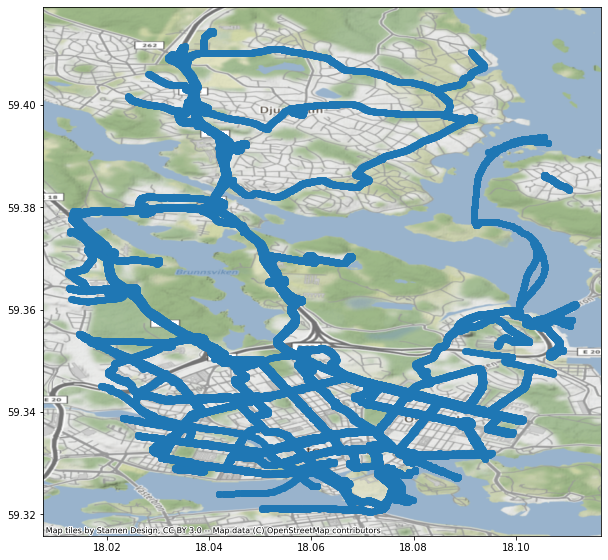

In [40]:
poit = Point( 18.062403913947964, 59.36964634265868)

fig, ax = plt.subplots(figsize=(10,10))
gdf[gdf.distance(poit) < 0.05].plot(ax=ax)
cx.add_basemap(ax, crs=gdf.crs)

In [43]:
gdf_merged = gdf.merge(tvarb_tid, how='left', left_on='tid', right_on='trip_id')
gdf_merged = gdf_merged[gdf_merged.route_desc.str.contains('Tvär') == True]
gdf_merged.head()

,eid,timestamp,tid,vid,ts,geometry,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id,agency_id,route_short_name,route_long_name,route_type,route_desc


### Sadly, it seems like the tramway does not provide GPS data. 